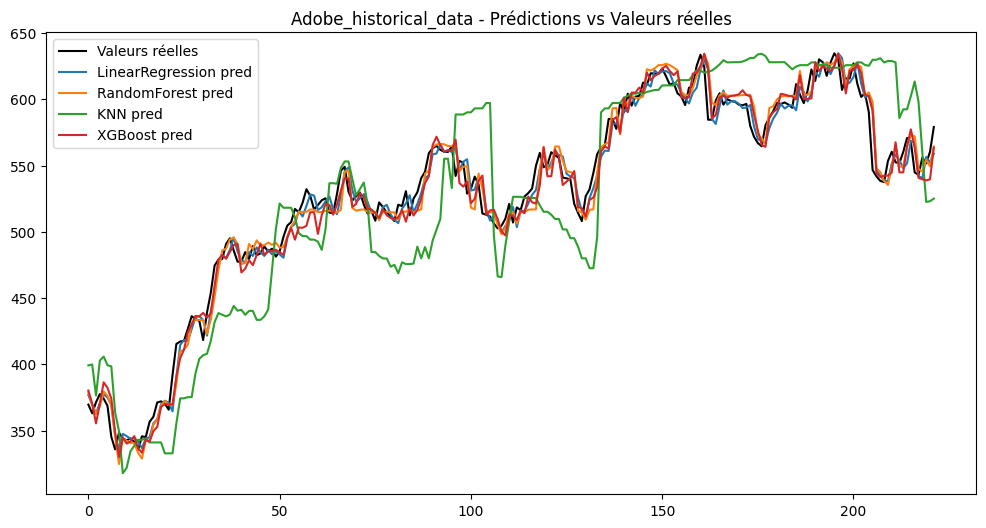

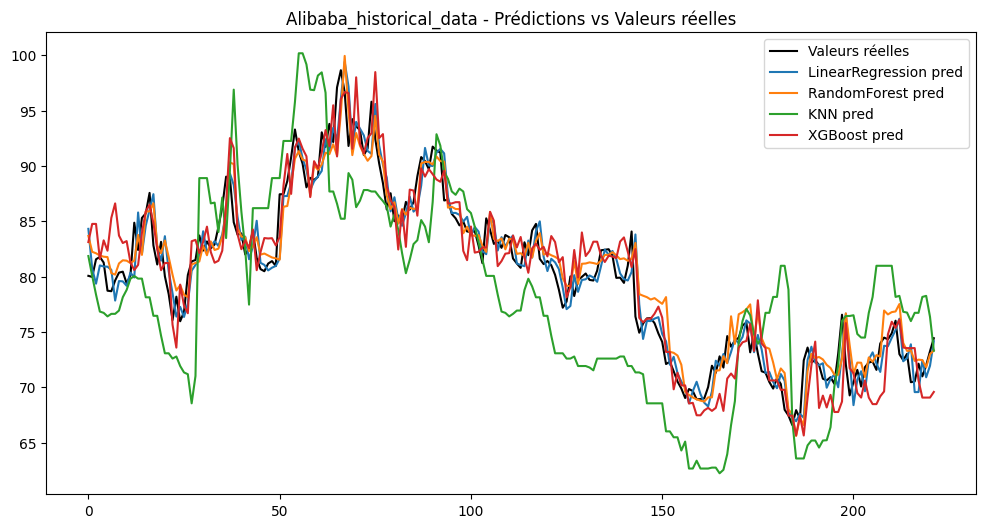

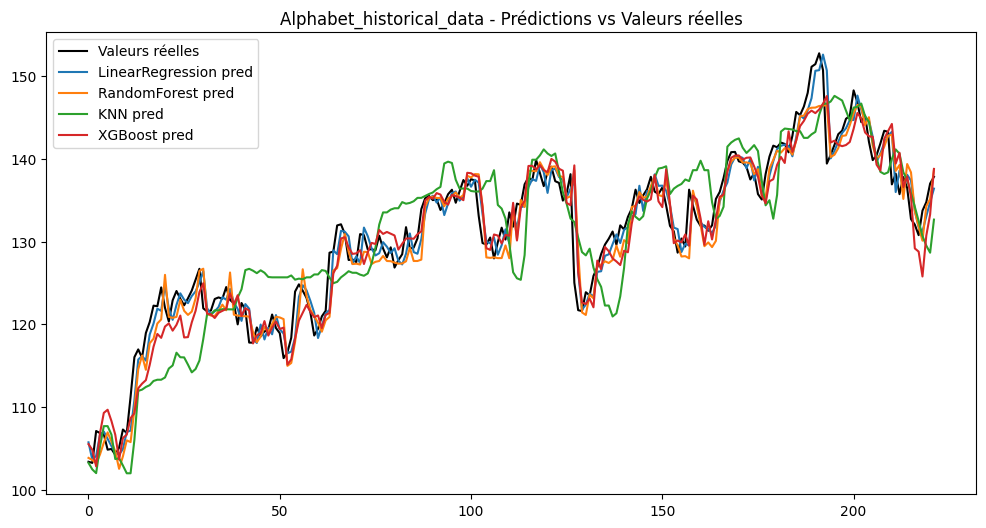

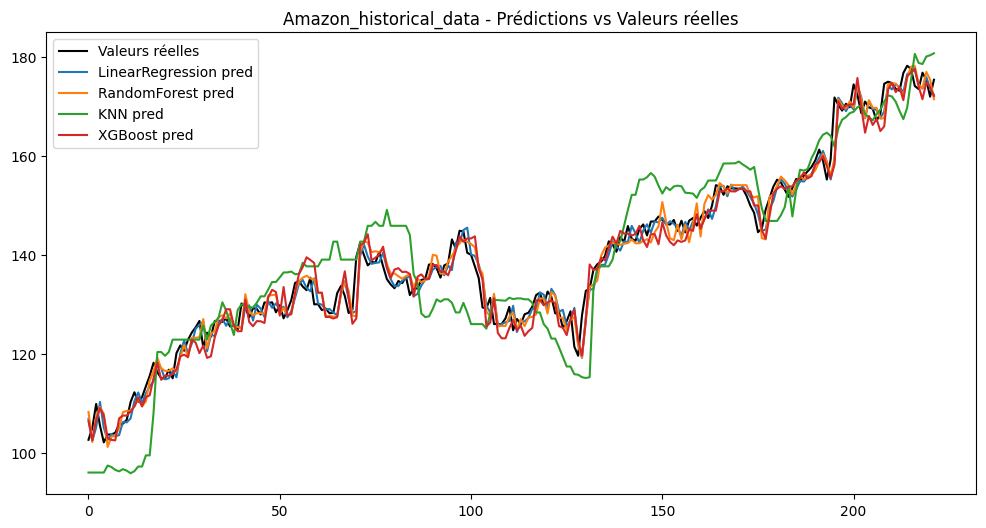

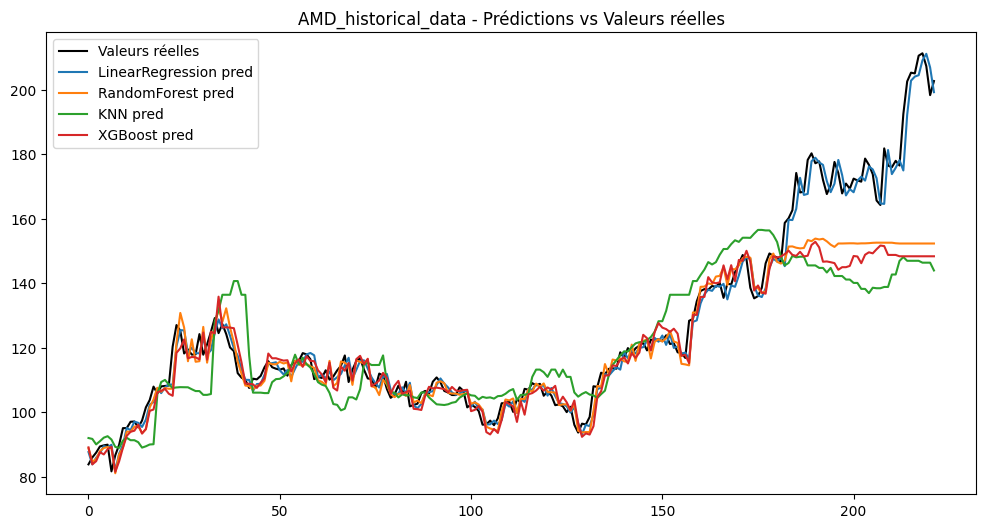

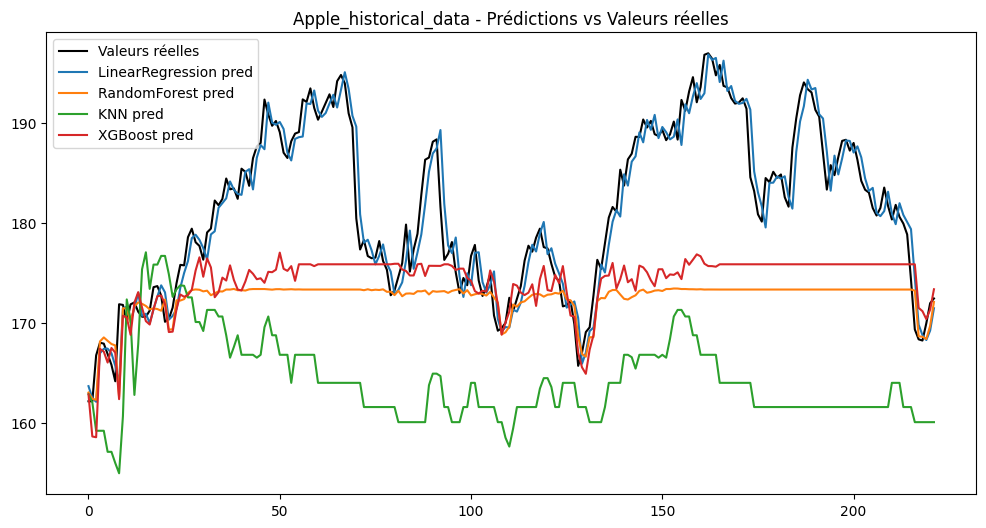

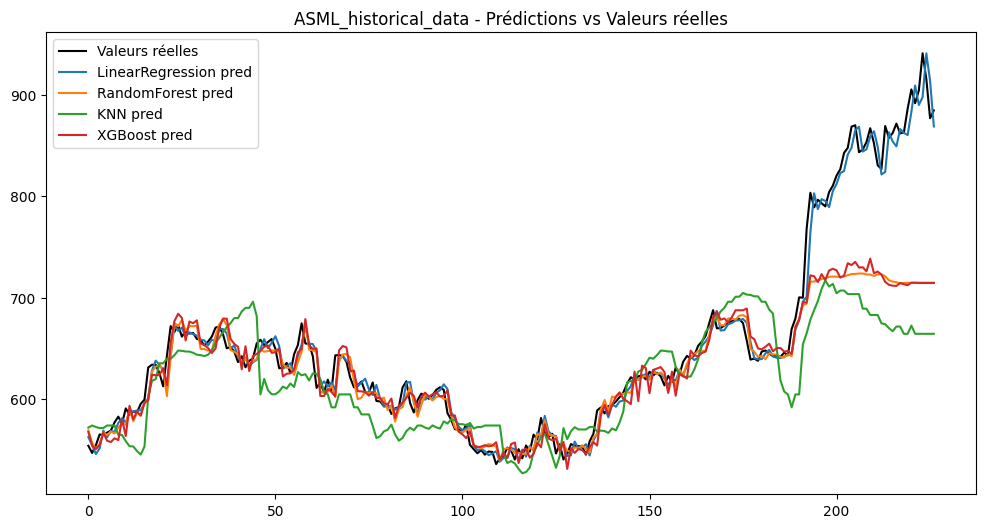

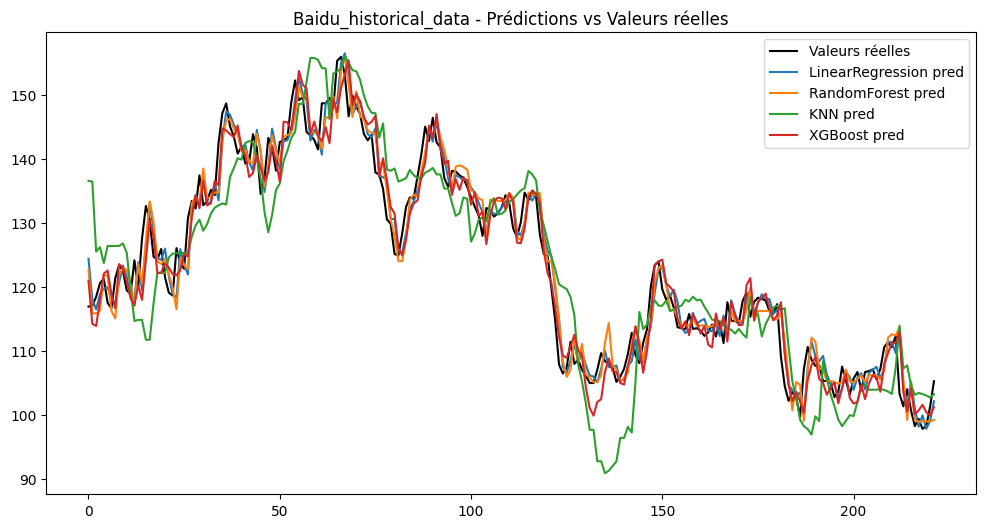

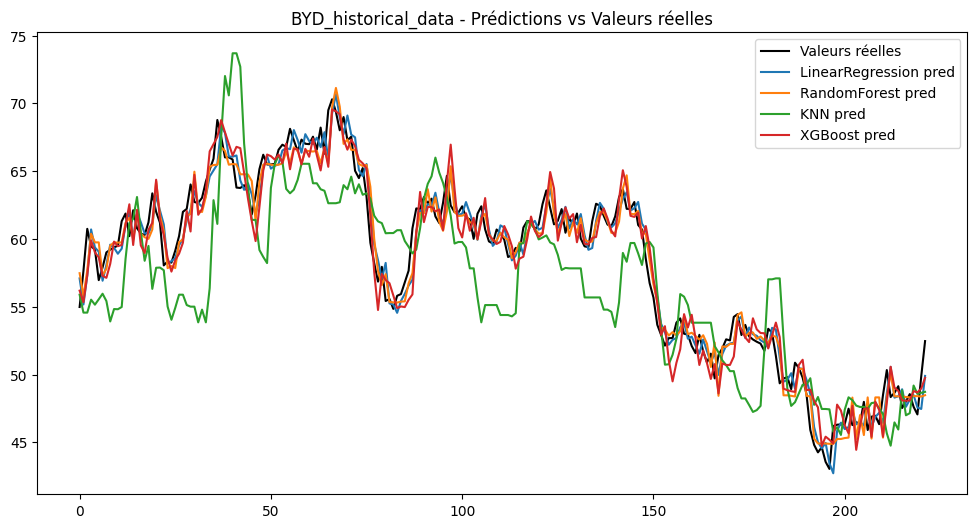

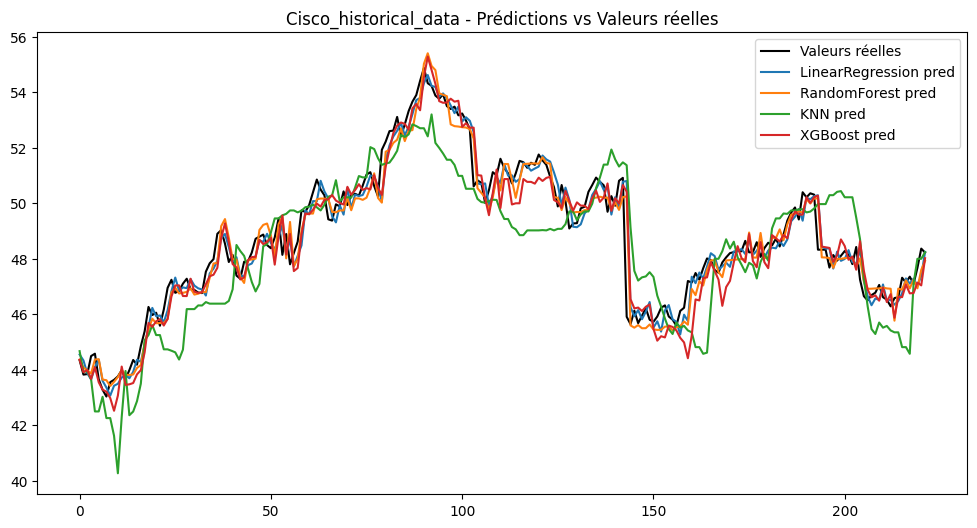

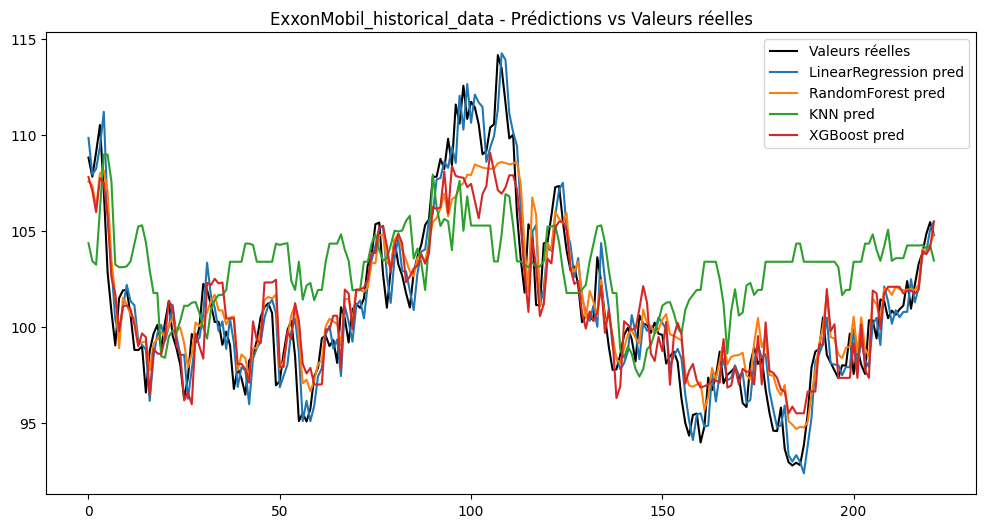

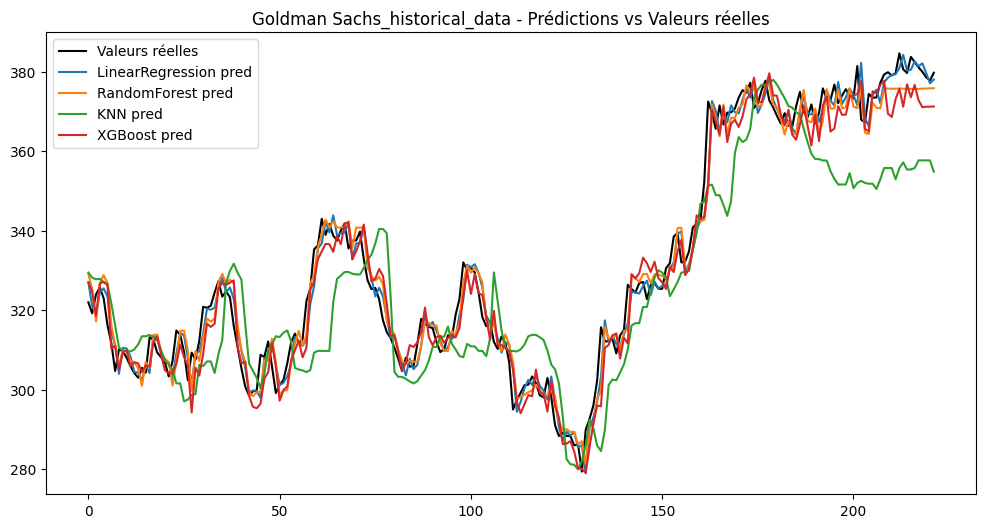

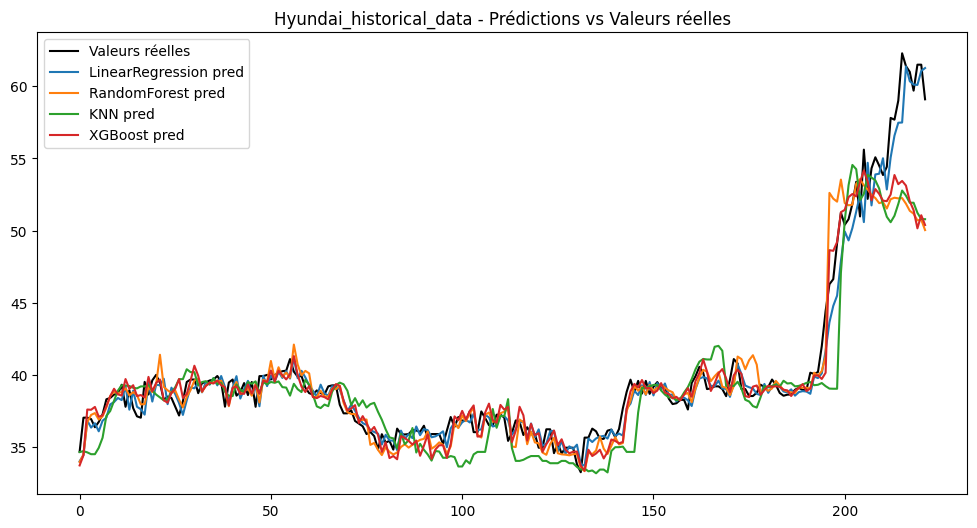

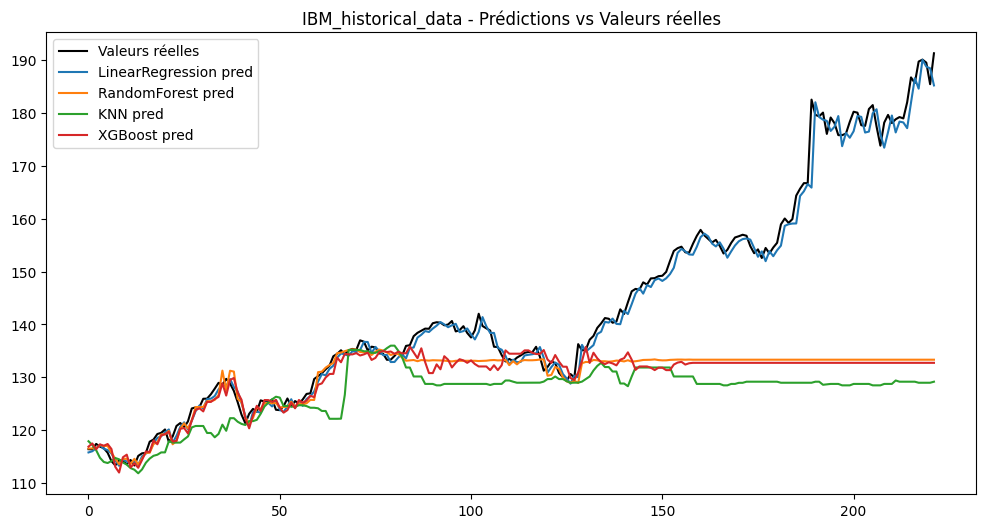

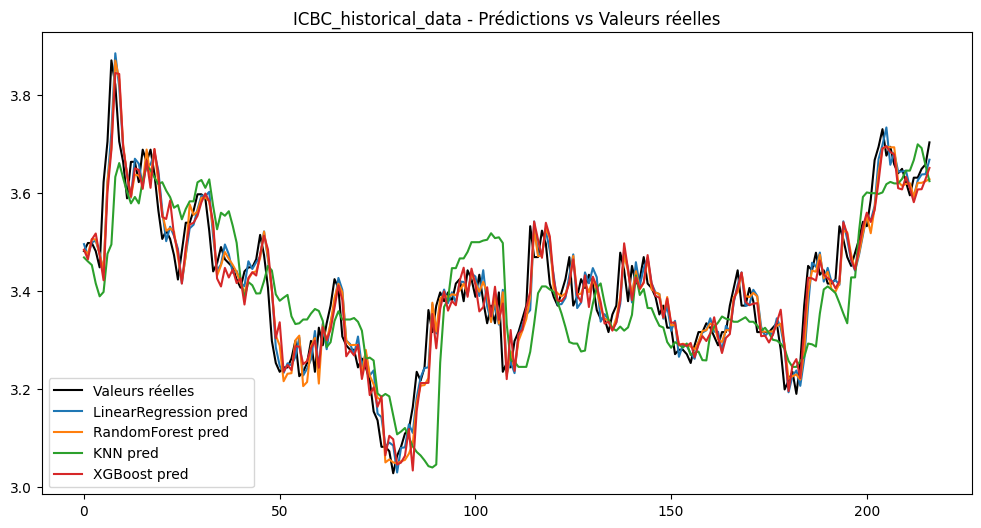

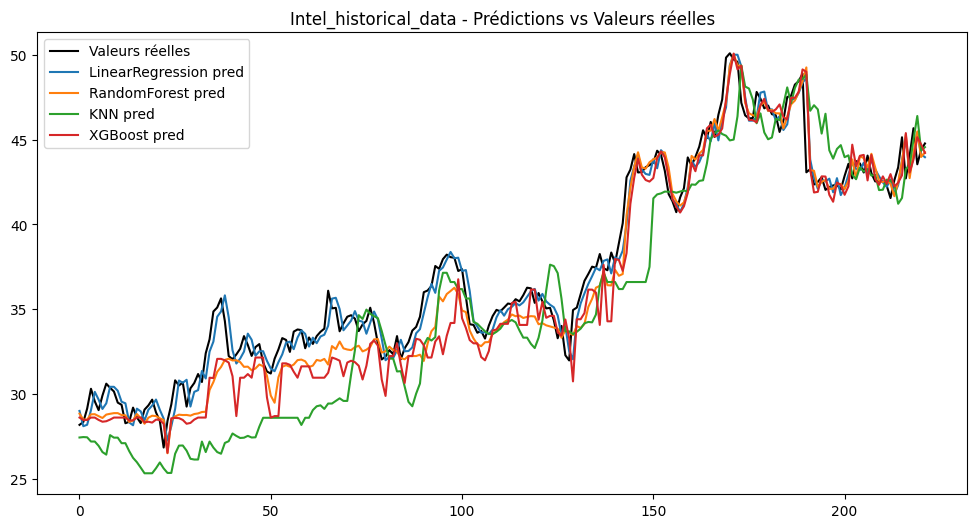

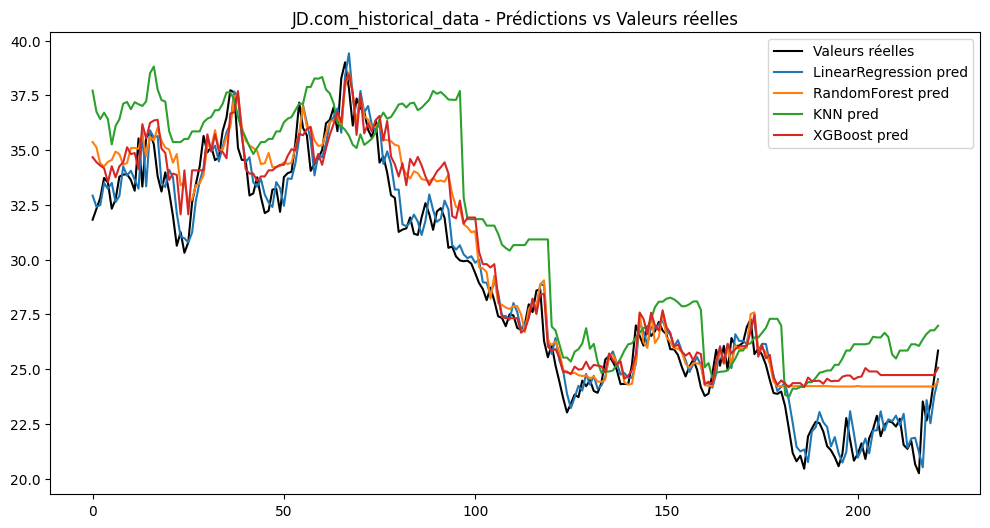

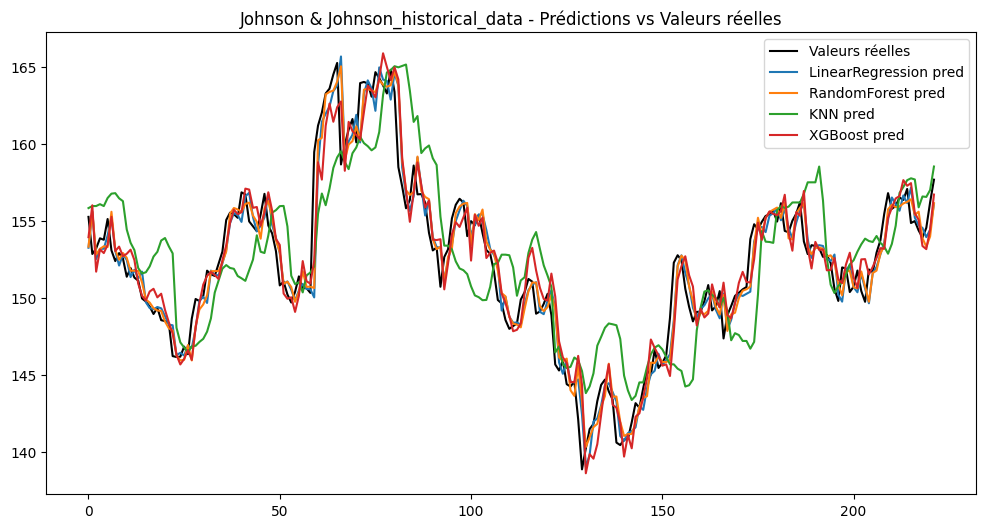

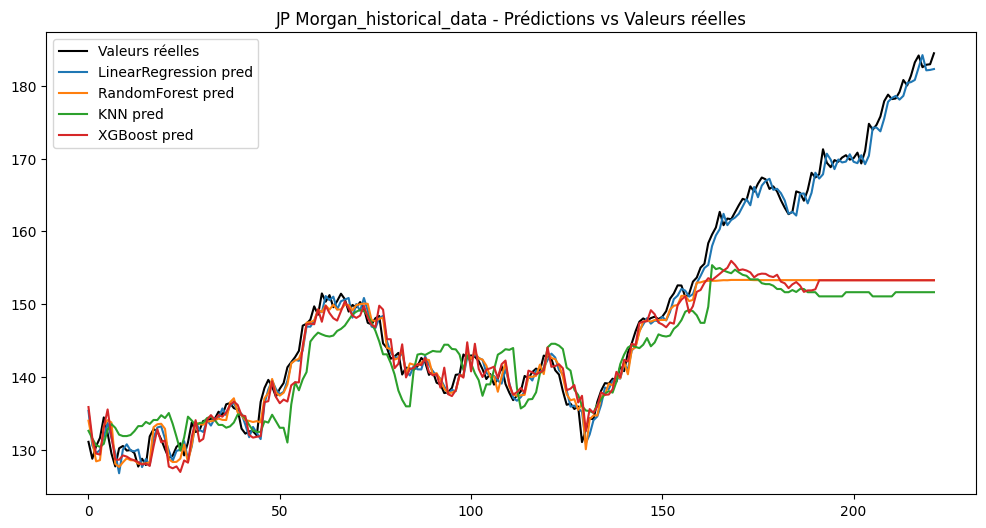

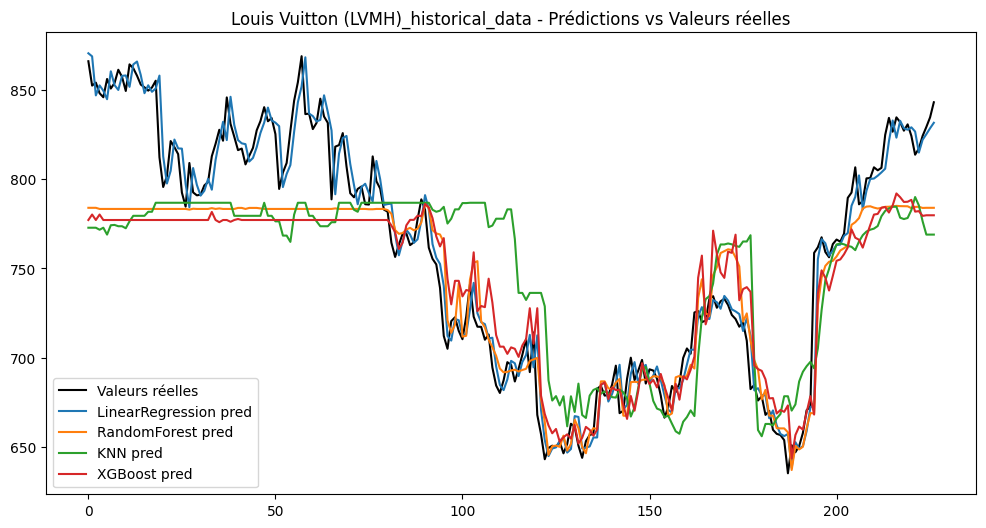

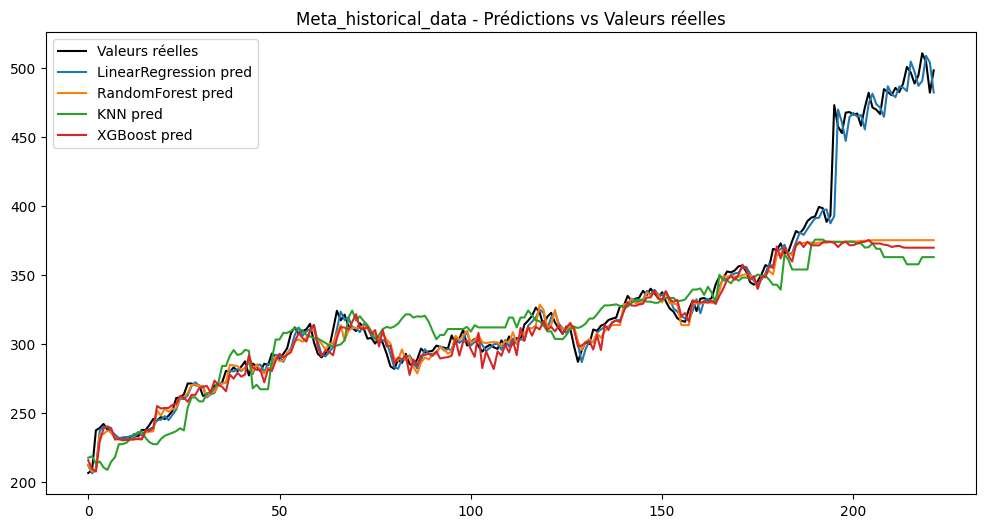

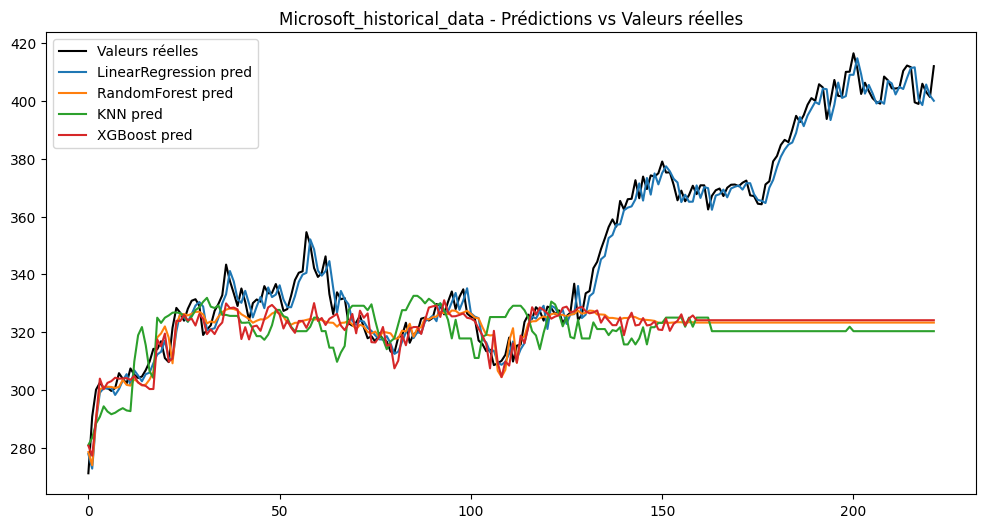

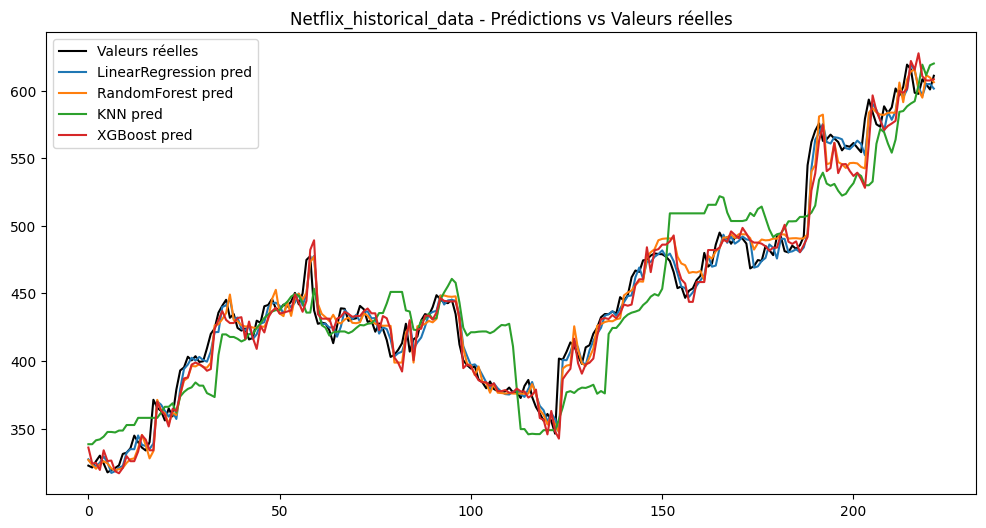

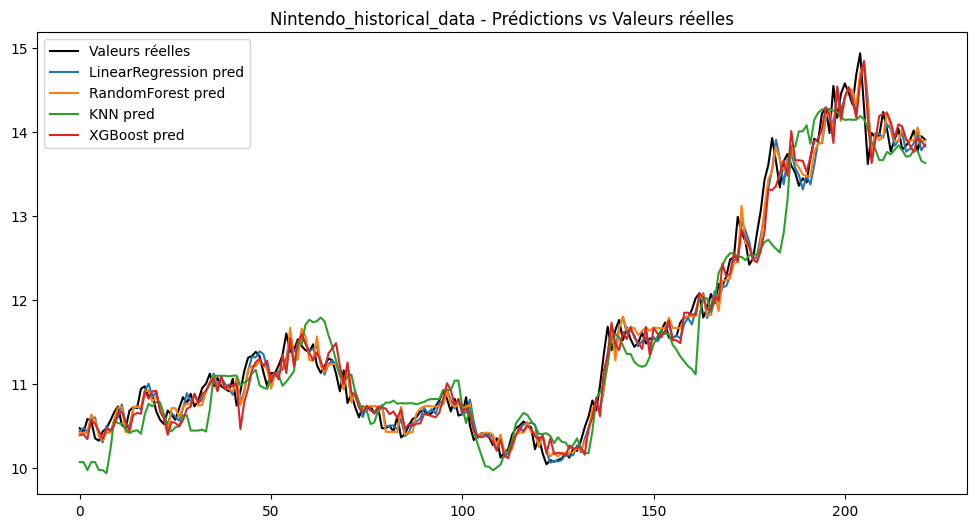

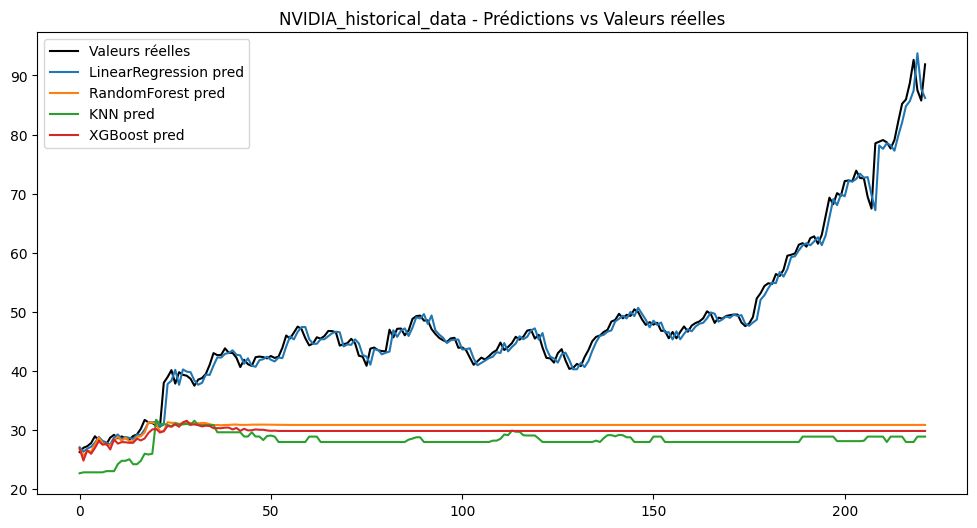

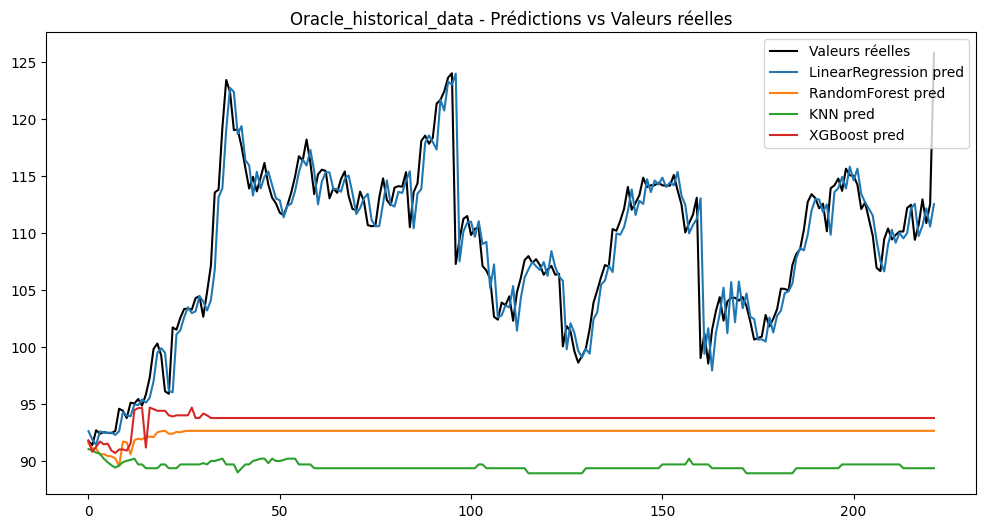

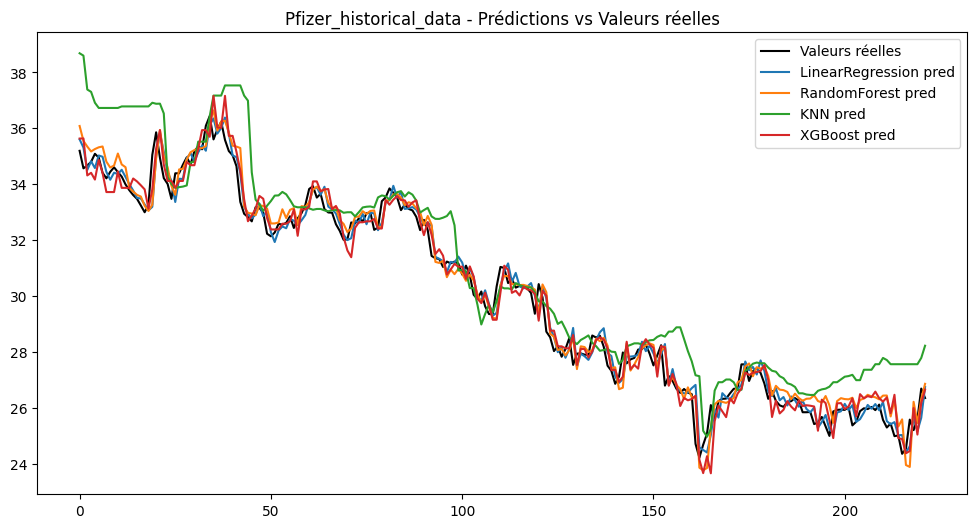

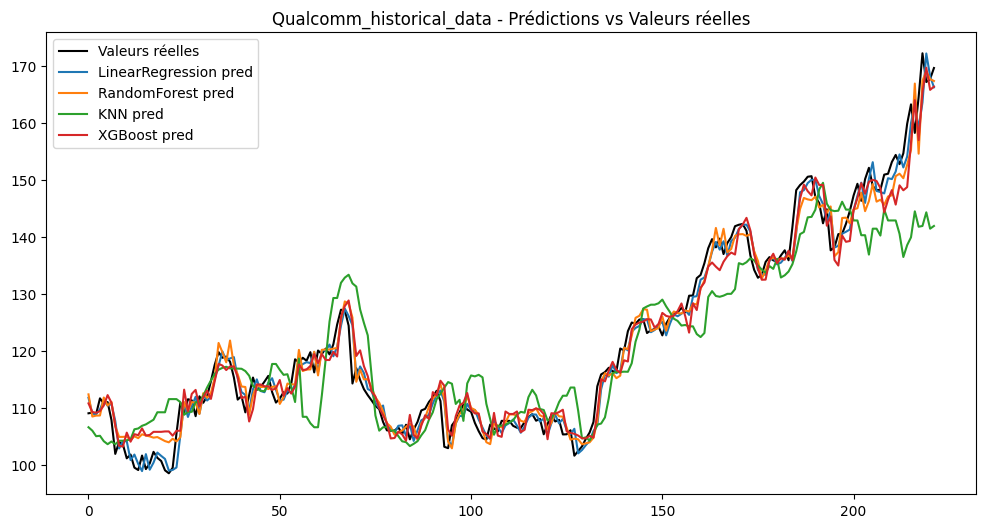

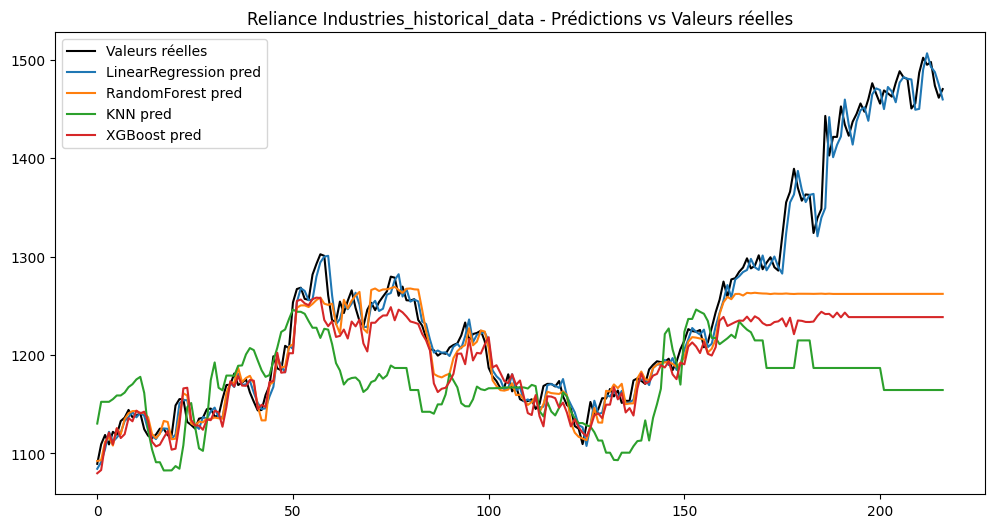

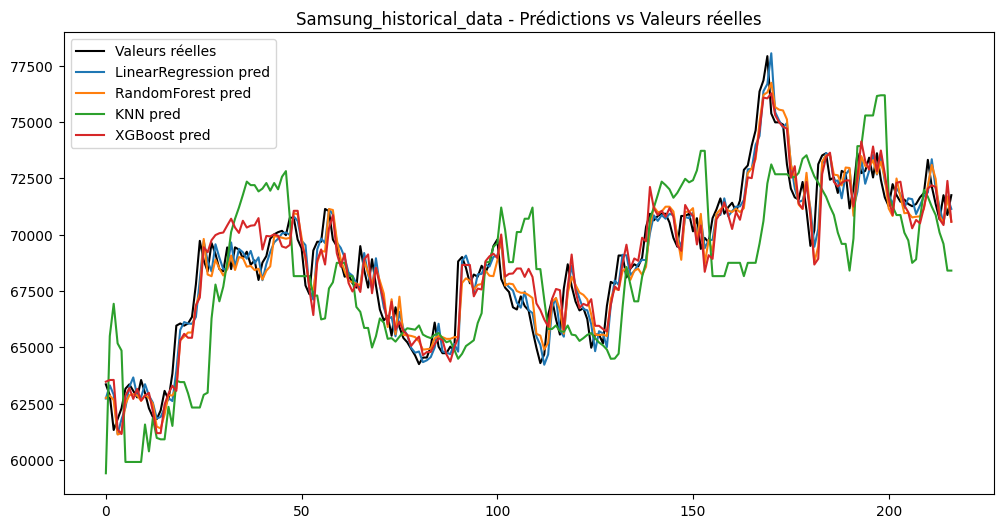

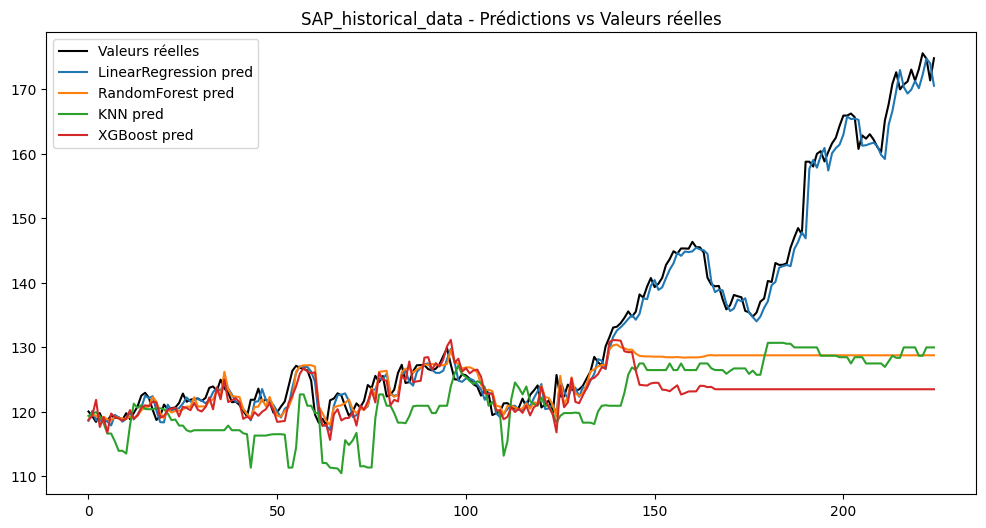

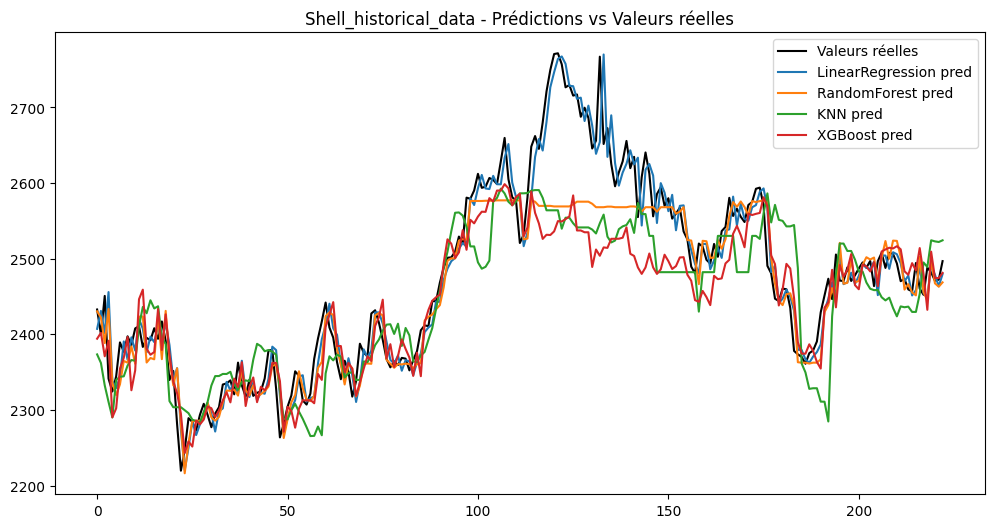

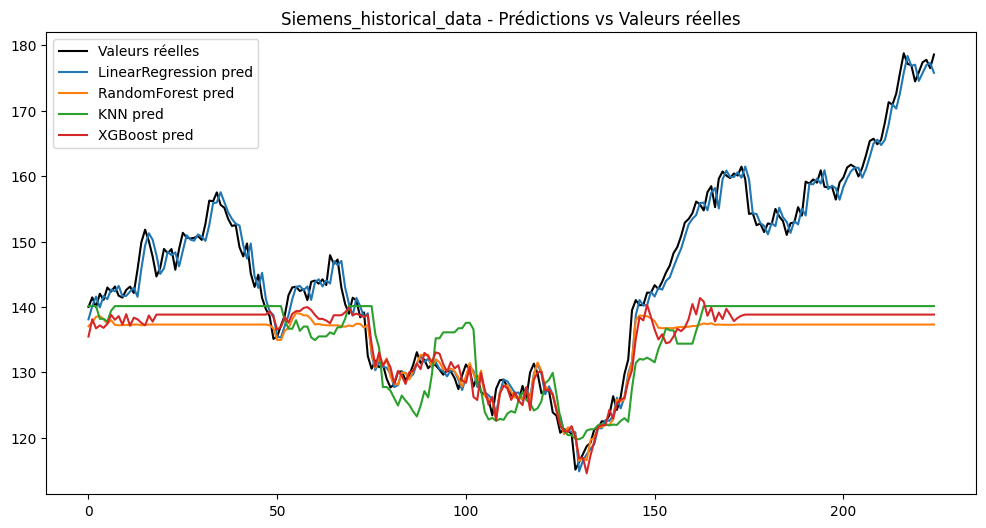

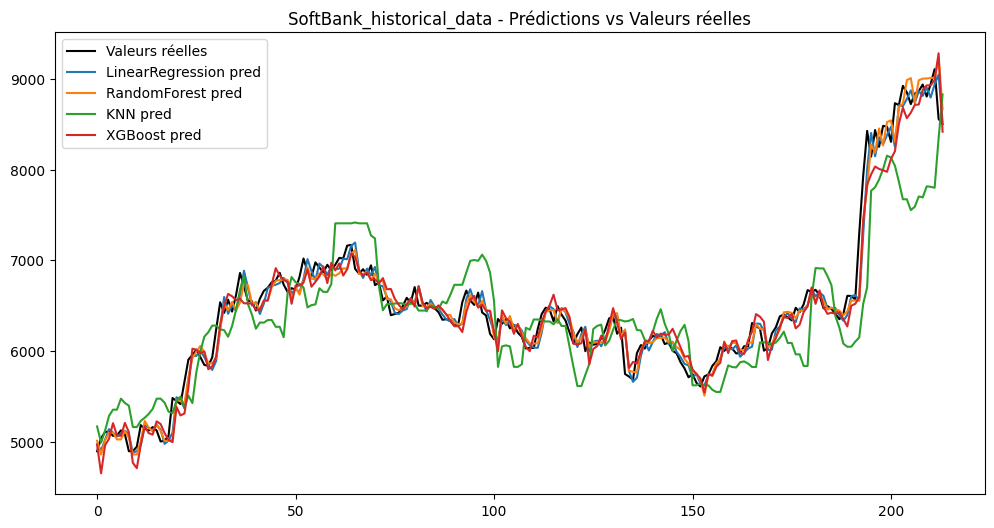

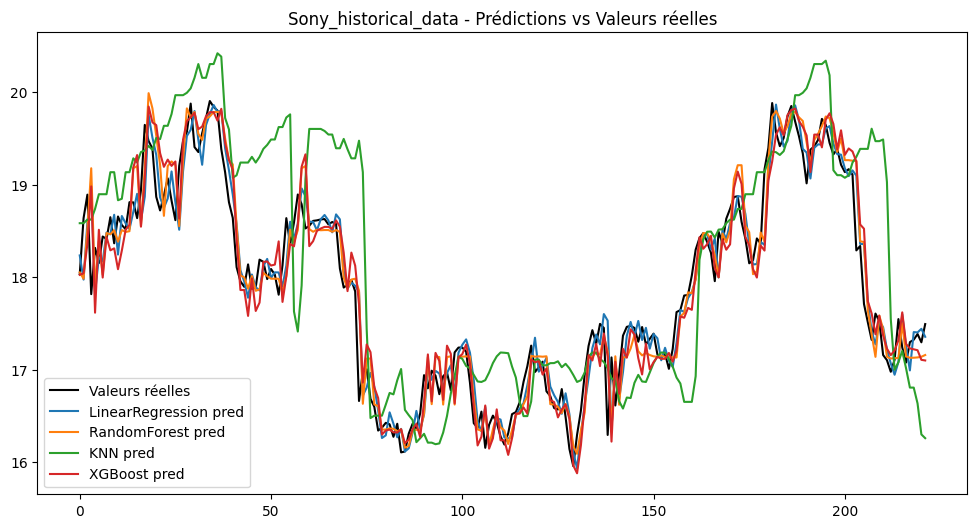

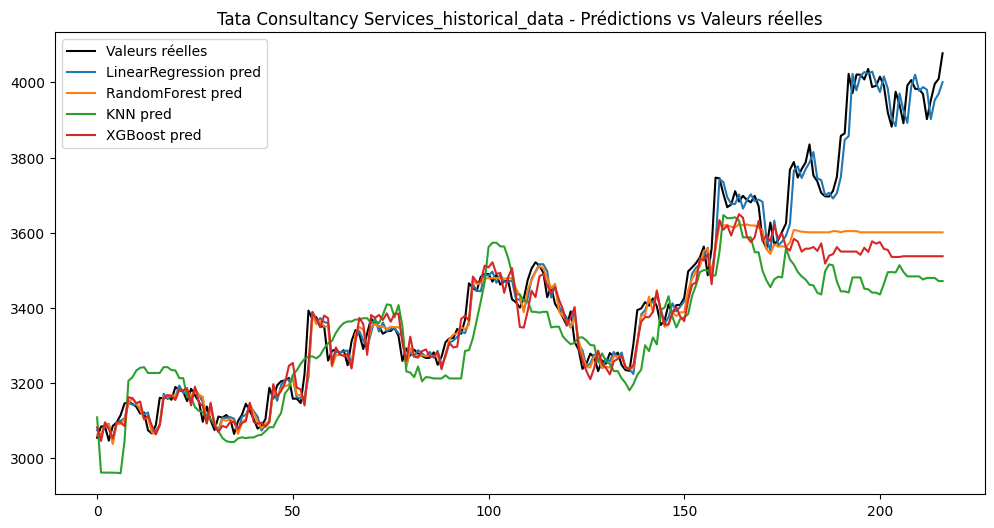

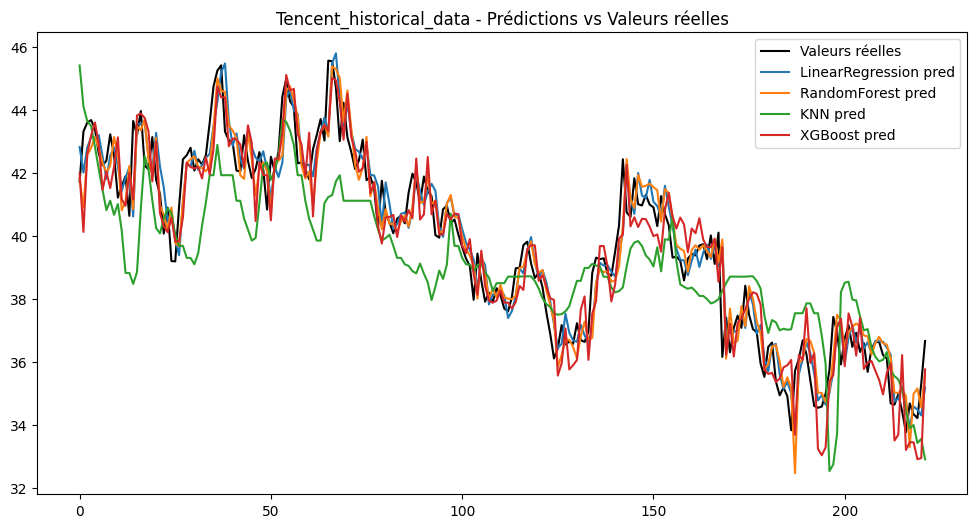

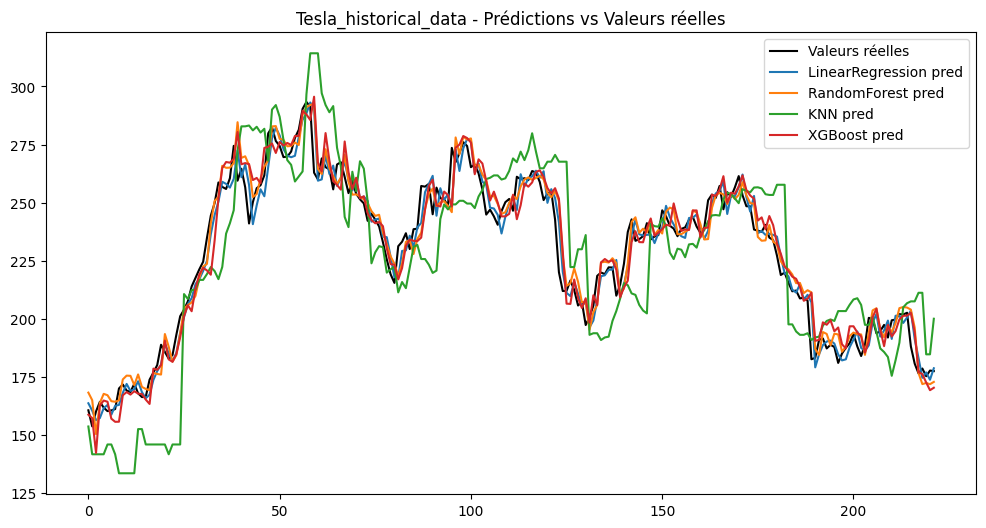

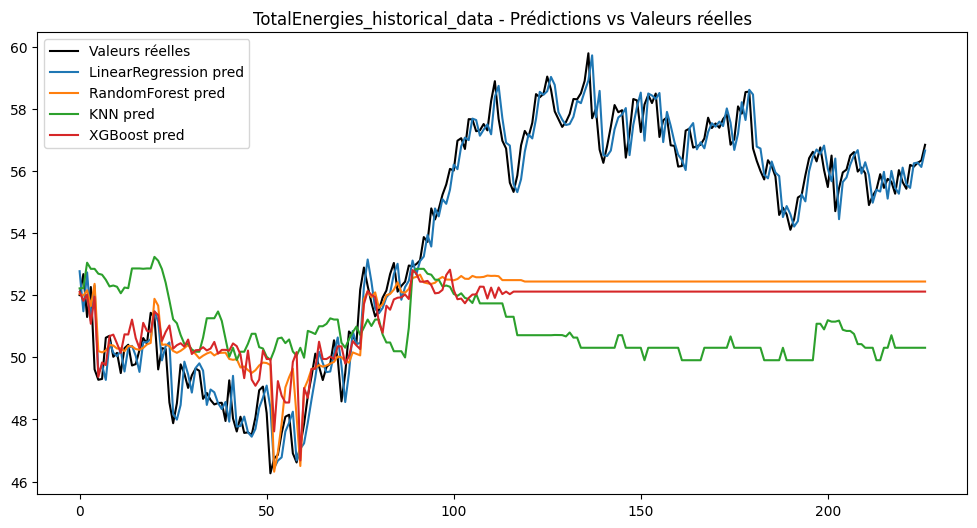

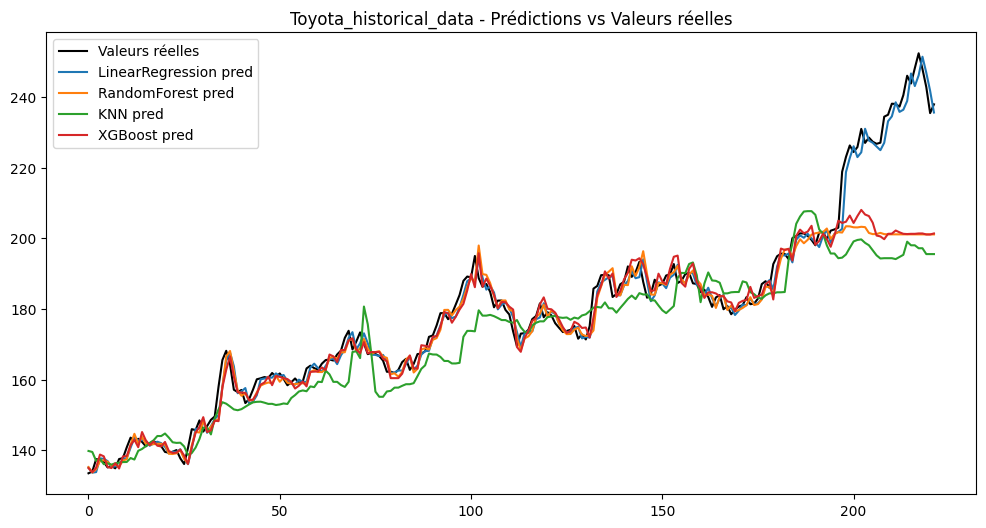

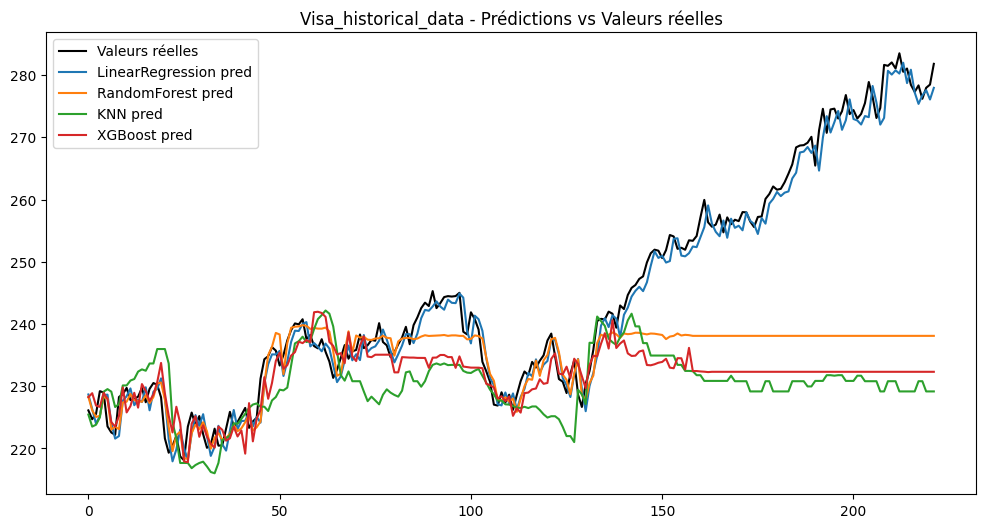

Entreprise            Modèle          MSE       RMSE
0      Adobe_historical_data  LinearRegression   114.696190  10.709631
1      Adobe_historical_data      RandomForest   144.537963  12.022394
2      Adobe_historical_data               KNN  1410.685924  37.559099
3      Adobe_historical_data           XGBoost   144.572947  12.023849
4    Alibaba_historical_data  LinearRegression     3.673536   1.916647
..                       ...               ...          ...        ...
159   Toyota_historical_data           XGBoost   133.506672  11.554509
160     Visa_historical_data  LinearRegression     6.620399   2.573014
161     Visa_historical_data      RandomForest   304.702120  17.455719
162     Visa_historical_data               KNN   482.561162  21.967275
163     Visa_historical_data           XGBoost   430.287271  20.743367

[164 rows x 4 columns]

In [3]:
import pandas as pd
import glob
import ta
import os
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

## ----- PARTIE 1 -----
# Chargement des prix close
def load_close_prices(file_path):
    df = pd.read_csv(file_path)
    return df[['Close']]

# Standardisation + split
def scale_and_split(data, split_ratio=0.8):
    scaler = MinMaxScaler()
    train_size = int(len(data) * split_ratio)
    train_data = data[:train_size]
    test_data = data[train_size:]
    train_scaled = scaler.fit_transform(train_data)
    test_scaled = scaler.transform(test_data)
    return train_scaled, test_scaled, scaler

# Création X et Y
def create_target_features(df_scaled, n_days=30):
    x = []
    y = []
    for i in range(n_days, len(df_scaled)):
        x.append(df_scaled[i - n_days:i, 0])
        y.append(df_scaled[i, 0])
    return np.array(x), np.array(y)

# Pipeline complet pour un fichier
def prepare_dataset(file_path, n_days=30, split_ratio=0.8):
    df = load_close_prices(file_path)
    train_scaled, test_scaled, scaler = scale_and_split(df, split_ratio)
    x_train, y_train = create_target_features(train_scaled, n_days)
    x_test, y_test = create_target_features(test_scaled, n_days)
    return x_train, y_train, x_test, y_test, scaler

## ---- PARTIE 2 -----
# Fonction générique d’entraînement + évaluation
def train_and_evaluate_model(model, param_grid, x_train, y_train, x_test, y_test, scaler):
    grid = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error', verbose=0)
    grid.fit(x_train, y_train)

    best_model = grid.best_estimator_
    predictions = best_model.predict(x_test)

    y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
    pred_inv = scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()

    mse = mean_squared_error(y_test_inv, pred_inv)
    rmse = np.sqrt(mse)

    return pred_inv, y_test_inv, mse, rmse

models = {
    "LinearRegression": (LinearRegression(), {}),
    "RandomForest": (RandomForestRegressor(), {'n_estimators': [100], 'max_depth': [5, 10]}),
    "KNN": (KNeighborsRegressor(), {'n_neighbors': [3, 5]}),
    "XGBoost": (XGBRegressor(verbosity=0), {'n_estimators': [100], 'max_depth': [3, 6]})
}

# Generation de la dataframe
def get_regression_results(folder_path, n_days=30):
    results_summary = []
    all_predictions = {}  # Pour stocker les courbes plus tard

    files = glob.glob(os.path.join(folder_path, "*.csv"))

    for file in files:
        company = os.path.basename(file).replace(".csv", "")

        x_train, y_train, x_test, y_test, scaler = prepare_dataset(file, n_days=n_days)
        y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

        all_predictions[company] = {"real": y_test_inv}

        for model_name, (model, params) in models.items():
            pred, y_true, mse, rmse = train_and_evaluate_model(
                model, params, x_train, y_train, x_test, y_test, scaler
            )

            results_summary.append({
                "Entreprise": company,
                "Modèle": model_name,
                "MSE": mse,
                "RMSE": rmse
            })

            all_predictions[company][model_name] = pred

    return pd.DataFrame(results_summary), all_predictions

# Generation des graphes
def plot_predictions(predictions_dict):
    for company, data in predictions_dict.items():
        plt.figure(figsize=(12, 6))
        plt.title(f"{company} - Prédictions vs Valeurs réelles")

        plt.plot(data["real"], label="Valeurs réelles", color="black")
        for model_name, pred in data.items():
            if model_name != "real":
                plt.plot(pred, label=f"{model_name} pred")

        plt.legend()
        plt.show()

# Génération des résultats
results_df, all_preds = get_regression_results("Companies_historical_data")

# Affichage des graphes
plot_predictions(all_preds)
results_df